This notebook features the training and creation of a Long Short-Term Memory (LSTM) recurrent neural networks based on TensorFlow.

## 1. Dependencies

In [2]:
# standard libraries
from datetime import datetime
import numpy as np
import pandas as pd
import time
import os
from math import sqrt

# machine learning libraries
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# deep learning libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt

## 2. Data Import

source of test data: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

The complete feature list in the raw data is as follows:

- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- pm2.5: PM2.5 concentration
- DEWP: Dew Point
- TEMP: Temperature
- PRES: Pressure
- cbwd: Combined wind direction
- Iws: Cumulated wind speed
- Is: Cumulated hours of snow
- Ir: Cumulated hours of rain

In [4]:
# set path
data_path = "../00_data"

In [5]:
# import test data
df = pd.read_csv(os.path.join(data_path, "test.csv"), sep=",")

## 3. Data Cleaning

In [ ]:
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv(os.path.join(data_path, "test.csv"),  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv(data_path + 'pollution.csv')

## 4. Define and Fit Model

We frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

In [69]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = pd.read_csv(data_path + 'pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [70]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

Epoch 1/50
122/122 - 3s - loss: 0.0593 - val_loss: 0.0548
Epoch 2/50
122/122 - 1s - loss: 0.0421 - val_loss: 0.0582
Epoch 3/50
122/122 - 1s - loss: 0.0274 - val_loss: 0.0505
Epoch 4/50
122/122 - 1s - loss: 0.0189 - val_loss: 0.0418
Epoch 5/50
122/122 - 1s - loss: 0.0163 - val_loss: 0.0280
Epoch 6/50
122/122 - 1s - loss: 0.0153 - val_loss: 0.0192
Epoch 7/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0162
Epoch 8/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0151
Epoch 9/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0149
Epoch 10/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0147
Epoch 11/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0147
Epoch 12/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0145
Epoch 13/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0143
Epoch 14/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0141
Epoch 15/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0140
Epoch 16/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0139
Epoch 17/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0137
Epoch 

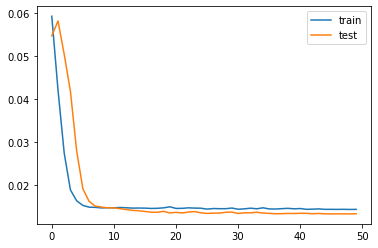

In [71]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 5. Evaluate Model

In [64]:
# make prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.485
